In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import levene

In [2]:
n_threads = 5

In [3]:
df_res = None
for i in range(n_threads):
    df = pd.read_csv(f'./out_mp/stream_{i}.csv')
    df['delay'] = df['arrival_time'] - df['event_time']
    df['thread'] = i
    if df_res is not None:
        df_res = pd.concat([df_res, df])
    else:
        df_res = df

In [4]:
df_res.head()

,arrival_time,event_time,updateId,delay,thread
0,1.692440e+12,1692440055544,3180676699005,661.601074,0
1,1.692440e+12,1692440055581,3180676700083,661.604980,0
2,1.692440e+12,1692440055581,3180676700102,661.604980,0
3,1.692440e+12,1692440055591,3180676700330,662.124023,0
4,1.692440e+12,1692440055591,3180676700339,663.125244,0


C:\Users\Custos\PycharmProjects\alberBlancTest\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


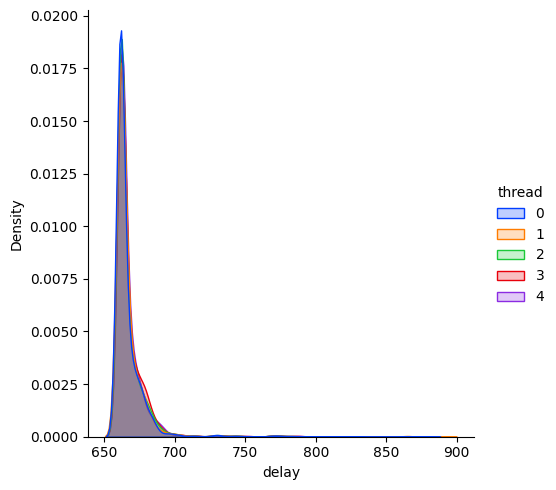

In [5]:
sns.displot(data=df_res, x='delay', hue='thread', kind='kde', fill=True, palette=sns.color_palette('bright')[:n_threads])

In [6]:
pivot_df = df_res.pivot(index='updateId', columns='thread', values='delay')
# We could use this code, but it gives advantage to first threads since if values are identical only first thread will be counted
# pivot_df['lowest_thread'] = pivot_df.apply(lambda row: row[1:].idxmin(), axis=1)

# Instead, let's count percentages for each thread by hand
def find_lowest_threads(row):
    lowest_value = row.min()
    lowest_threads = list(row.loc[row == lowest_value].index)
    return lowest_threads
    
pivot_df['lowest_threads'] = pivot_df.apply(find_lowest_threads, axis=1)
pivot_df.head()

thread,0,1,2,3,4,lowest_threads
updateId,,,,,,
3180676699005,661.601074,NaN,661.601074,662.603027,661.601074,"[0, 2, 4]"
3180676700083,661.604980,NaN,662.607422,662.607422,662.607422,[0]
3180676700102,661.604980,NaN,663.610596,663.610596,663.610596,[0]
3180676700330,662.124023,NaN,663.125244,663.125244,663.125244,[0]
3180676700339,663.125244,NaN,663.125244,663.125244,664.125000,"[0, 2, 3]"


In [7]:
counts = [0 for i in range(n_threads)]
for value_list in pivot_df['lowest_threads']:
    for value in value_list:
        counts[value] += 1

In [8]:
counts

[4915, 2796, 2855, 1632, 1355]

In [13]:
# Distribution of data is unknown (can't use t-test), we have several groups, so we will use Kruskal-Wallis test
# with H_0 that says that all medians are equal
data = []
for i in range(n_threads):
    thread_data = df_res[df_res['thread'] == i]
    data.append(thread_data['delay'])
stat, p = kruskal(*data)
print(p)
if p < 0.05:
    print('Medians are not equal')
else:
    print('Medians are equal')

3.376322097634173e-156
Medians are not equal


In [10]:
# Levene is non parametrical test for multiple samples
data = []
for i in range(n_threads):
    thread_data = df_res[df_res['thread'] == i]
    data.append(thread_data['delay'])
stat, p = levene(*data)
print(p)
if p < 0.05:
    print('Deviations are not equal')
else:
    print('Deviations are equal')

0.3277788172303471
Deviations are equal


# Conclusion

We can see that with multiprocessing module our distributions look almost similar, as it was expected. Also, we can see that deviations are statistically the same. However, medians are statistically different and we also see that thread 0 is generally faster(~2+ times more fast updates than any other thread)